#### Hierarchical classifiers - Tier 1

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pickle as pk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay, make_scorer, recall_score
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
import time

In [3]:
with open("x_training.pkl" , "rb") as file:
    x_training = pk.load(file)
with open("y_training.pkl" , "rb") as file:
    y_training = pk.load(file)

#### 1. Data processing  
I need to transform the y vector so that the class 2 becomes class 1 (class 1 will contain prediabetics and diabetics, class 0 remains healthy only)

In [4]:
# transform class 2 in class 1
y_training_first = np.where(y_training <= 1 , y_training , 1)

# checks
print(len(y_training) , len(y_training_first))
print(np.unique(y_training_first))

202945 202945
[0. 1.]


#### 2. Model evaluation
I will evaluate model performances on the new  binary problem.  
I will initially evaluate models looking in particular at recall of unhealthy class.  
Later I will decide the best classifier considering the diabetes and prediabetes recall.

In [5]:
# the HistGradientBoostingClassifier from scikit learn needs a boolean mask for categorical features

boolean_mask_tot = [False if col == "BMI" or col == "MentHlth" or col == "PhysHlth" else True for col in x_training.columns]

In [6]:
# I will only consider the models that performed well previously

logistic_reg = Pipeline([
    ('scaler', StandardScaler()), 
    ('lgr', LogisticRegression(
        solver="lbfgs", 
        max_iter=500, 
        class_weight="balanced"
    ))
])

hgbc = HistGradientBoostingClassifier(
    random_state = 42,
    class_weight="balanced",
    max_iter=500,
    categorical_features=boolean_mask_tot
)

bal_rfc = BalancedRandomForestClassifier(
    n_estimators = 500,
    replacement=False,
    random_state=42,
    n_jobs=-1    
)

eec = EasyEnsembleClassifier(
    n_estimators = 100,
    replacement=False,
    n_jobs=-1,
    random_state = 42    
)


# create a dictionary to iterate on models
models = {"LogisticRegression" : logistic_reg , "HistGradientBoostingClassifier" : hgbc, "BalancedRandomForest": bal_rfc, "EasyEnsembleClassifier" : eec}

In [7]:
# 10 fold cross validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [8]:
# define scoring function

def specificity(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)

scoring = {
    'recall_disease': 'recall', 
    'recall_healthy': make_scorer(specificity), 
    'mcc': make_scorer(matthews_corrcoef)
}

#### Performance on binary problem

In [9]:
# iterate on models and look at performances
results=[]
names=[]
for name, model in models.items():
        
    start = time.time()
    
    cv_recall = cross_validate(model, x_training, y_training_first, cv=cv, scoring=scoring)
    
    end = time.time()

    mcc_mean = cv_recall['test_mcc'].mean()
    mcc_std  = cv_recall['test_mcc'].std()
    rec_mean = cv_recall['test_recall_disease'].mean()
    rec_std  = cv_recall['test_recall_disease'].std()
    spc_mean = cv_recall['test_recall_healthy'].mean()
    spc_std  = cv_recall['test_recall_healthy'].std()
    
    sep = 35 - len(name)
    print(f"{name}"+"_"*sep+f"    mean mcc         = {mcc_mean:.4f}    std mcc         = {mcc_std:.4f}    time = {((end-start)/60):.2f}")
    print("_"*35+f"    mean recall      = {rec_mean:.4f}    std recall      = {rec_std:.4f}    ")
    print("_"*35+f"    mean specificity = {spc_mean:.4f}    std specificity = {spc_std:.4f}    ")
    print("\n")

    results.append(cv_recall)
    names.append(name)

LogisticRegression_________________    mean mcc         = 0.3698    std mcc         = 0.0047    time = 0.04
___________________________________    mean recall      = 0.7616    std recall      = 0.0038    
___________________________________    mean specificity = 0.7234    std specificity = 0.0032    


HistGradientBoostingClassifier_____    mean mcc         = 0.3734    std mcc         = 0.0037    time = 0.25
___________________________________    mean recall      = 0.7886    std recall      = 0.0046    
___________________________________    mean specificity = 0.7066    std specificity = 0.0036    


BalancedRandomForest_______________    mean mcc         = 0.3495    std mcc         = 0.0067    time = 3.05
___________________________________    mean recall      = 0.7750    std recall      = 0.0072    
___________________________________    mean specificity = 0.6911    std specificity = 0.0023    


EasyEnsembleClassifier_____________    mean mcc         = 0.3673    std mcc         = 0.

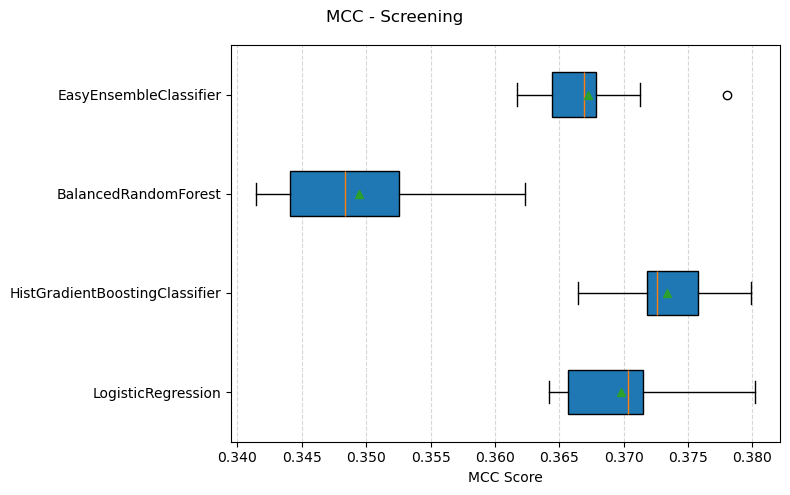

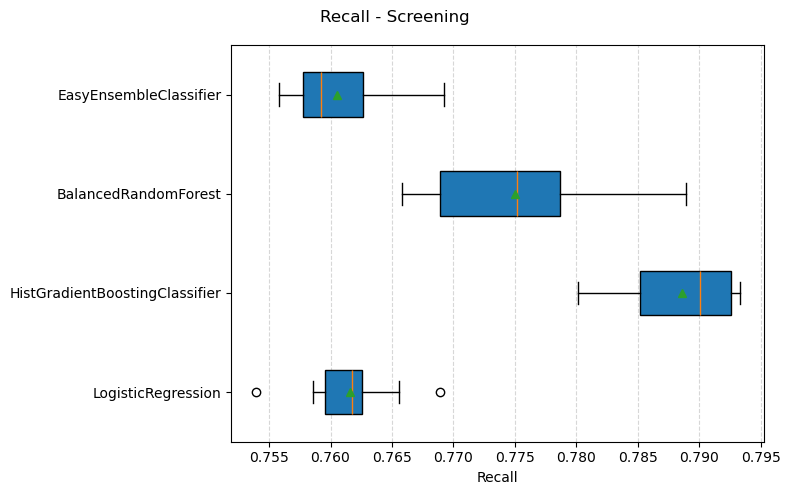

In [10]:
mcc_data = [res['test_mcc'] for res in results]
# plotting MCC
fig = plt.figure(figsize=(8, 5))
fig.suptitle("MCC - Screening")
ax = fig.add_subplot(111)
plt.boxplot(mcc_data, vert=False, labels=names, showmeans=True, patch_artist=True)
ax.set_xlabel('MCC Score')
ax.grid(True, axis='x', linestyle='--', alpha=0.5) 
plt.tight_layout()
plt.show()


recall_data = [res['test_recall_disease'] for res in results]
# plotting Recall
fig = plt.figure(figsize=(8, 5))
fig.suptitle("Recall - Screening")
ax = fig.add_subplot(111)
plt.boxplot(recall_data, vert=False, labels=names, showmeans=True, patch_artist=True)
ax.set_xlabel('Recall')
ax.grid(True, axis='x', linestyle='--', alpha=0.5) 
plt.tight_layout()
plt.show()

#### 3.Results healthy vs disease
The most important metric in this case is recall. 
EasyEnsembleClassifier was the worst performer.  
HistGradientBoosting was the best model for both recall and MCC, but I know from previous tests that it is a better at recalling diabetes patients than prediabetes.  
Logistic regression was outperformed but I know it is better for prediabetes than HistGradientBoosting.  
BalancedRandomForest was a good performer, and I know it is the best for recalling prediabetes.

I will therefore no longer consider the EasyEnsembleClassifier model and focus on the remaining 3.

#### 4. Considerations and final test
Considering this specific problem, In my opinion recalling prediabetics is more important than recalling diabetics.  
This is simply because prediabetes is a "silent" condition. People with prediabetes may not experience relevant symptoms, but if untreated, prediabetics will become full diabetic usually in a 5 year window.
Most importantly, prediabetes can (even if very rarely) be reversed, while diabetes cannot.  
Diabetes on the other hand is a morbid medical condition, and it is unlikely that someone is diabetic and does not know it already.  

In a real case scenario most diabetics are already diagnosed, while prediabetics are not. 
It is also very important to have decent healthy specificity to avoid predicting everybody as diseased.  
Therefore I will now consider prediabetic recall only, and use this metric to decide the final classifier.  

In [11]:
# divide training set in temporary set + testing set. (80% , 20%)
x_temp, x_test, y_temp, y_test = train_test_split(
    x_training, y_training, test_size=0.2, stratify=y_training, random_state=42
)

# divide temporary set in train + validation (60% , 20% , 20%)
x_train, x_val, y_train, y_val = train_test_split(
    x_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

# create binary vector for training and validation
y_train_first = np.where(y_train <= 1 , y_train , 1)
y_val_first = np.where(y_val <= 1 , y_val , 1)

#### Threshold tuning

The models only see binary labels during training (healthy - disease).  
But I look at subclass (diabetes, prediabetes) recall.

In [12]:
# i will test different probability thresholds to recall more prediabetics as possible

thresholds = np.arange(0.1, 0.75, 0.05) # from 0.1 to 0.75 
models.pop("EasyEnsembleClassifier")


for name, model in models.items():
    print(f"\n{'='*30} {name} {'='*30}")
    
    # training on binary vector
    model.fit(x_train, y_train_first)
    
    # obtain class 1 probability
    probs_val = model.predict_proba(x_val)[:, 1]
    probs_test = model.predict_proba(x_test)[:, 1]

    print(f"{'THR':<5} | {'VAL Pre':<8} | {'VAL Dia':<8} | {'VAL Spec':<8} || {'TEST Pre':<8} | {'TEST Dia':<8} | {'TEST Spec':<8}")
    print("-" * 100)
    
    # threshold testing
    for t in thresholds:

         # validation
        preds_val = (probs_val >= t).astype(int)
        df_val = pd.DataFrame({'Real': y_val, 'Pred': preds_val})
        
        v_rec_pre = df_val[df_val['Real'] == 1]['Pred'].mean()
        v_rec_dia = df_val[df_val['Real'] == 2]['Pred'].mean()
        v_spec    = df_val[df_val['Real'] == 0]['Pred'].apply(lambda x: 1 if x==0 else 0).mean()

        # testing
        preds_test = (probs_test >= t).astype(int)
        df_test = pd.DataFrame({'Real': y_test, 'Pred': preds_test})
        
        t_rec_pre = df_test[df_test['Real'] == 1]['Pred'].mean()
        t_rec_dia = df_test[df_test['Real'] == 2]['Pred'].mean()
        t_spec    = df_test[df_test['Real'] == 0]['Pred'].apply(lambda x: 1 if x==0 else 0).mean()

        # Marker if recall > 90%
        marker = " <---" if t_rec_pre >= 0.90 else ""
        
        print(f"{t:.2f}  | {v_rec_pre:.4f}   | {v_rec_dia:.4f}   | {v_spec:.4f}   || {t_rec_pre:.4f}   | {t_rec_dia:.4f}   | {t_spec:.4f}{marker}")


============================== LogisticRegression ==============================
THR   | VAL Pre  | VAL Dia  | VAL Spec || TEST Pre | TEST Dia | TEST Spec
----------------------------------------------------------------------------------------------------
0.10  | 0.9784   | 0.9961   | 0.1727   || 0.9852   | 0.9961   | 0.1709 <---
0.15  | 0.9474   | 0.9883   | 0.2752   || 0.9663   | 0.9873   | 0.2787 <---
0.20  | 0.9190   | 0.9779   | 0.3631   || 0.9298   | 0.9747   | 0.3674 <---
0.25  | 0.8880   | 0.9577   | 0.4409   || 0.8961   | 0.9546   | 0.4432
0.30  | 0.8475   | 0.9365   | 0.5080   || 0.8489   | 0.9287   | 0.5112
0.35  | 0.7962   | 0.9066   | 0.5687   || 0.7962   | 0.8994   | 0.5722
0.40  | 0.7368   | 0.8700   | 0.6250   || 0.7584   | 0.8642   | 0.6252
0.45  | 0.6842   | 0.8304   | 0.6758   || 0.7139   | 0.8255   | 0.6751
0.50  | 0.6302   | 0.7818   | 0.7234   || 0.6640   | 0.7777   | 0.7243
0.55  | 0.5628   | 0.7291   | 0.7674   || 0.5884   | 0.7248   | 0.7689
0.60  | 0.4899   |

#### Confusion Matrix at best Threshold: prediabetes vs healthy 

In [17]:
def predict_custom(model, x, threshold):

    ''' function to enable the use of a selected threshold
        for classification'''
    
    # predict probabilities instead of just predict
    probs = model.predict_proba(x)[:, 1]
    # apply thresholds
    return (probs >= threshold).astype(int)

In [18]:
# divide training set in test + train
x_train, x_test, y_train, y_test = train_test_split(
    x_training, y_training, test_size=0.2, stratify=y_training, random_state=42
)

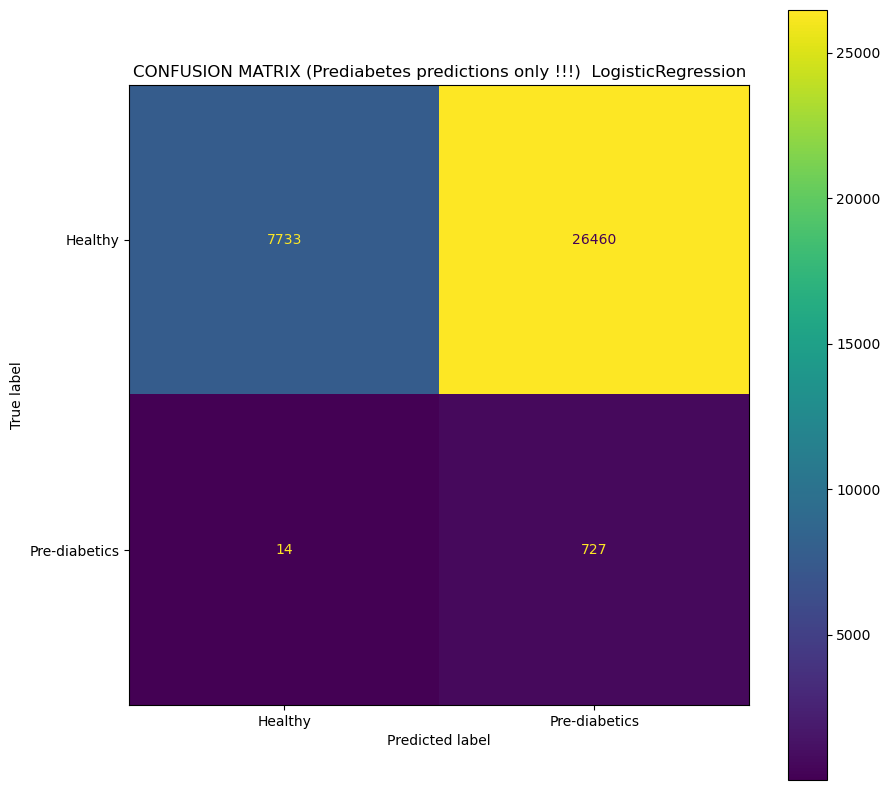

False alarms: 26460
Catches:  727
Ratio: 36.4
---------------------------------------------------------------------------------------------------------------------------


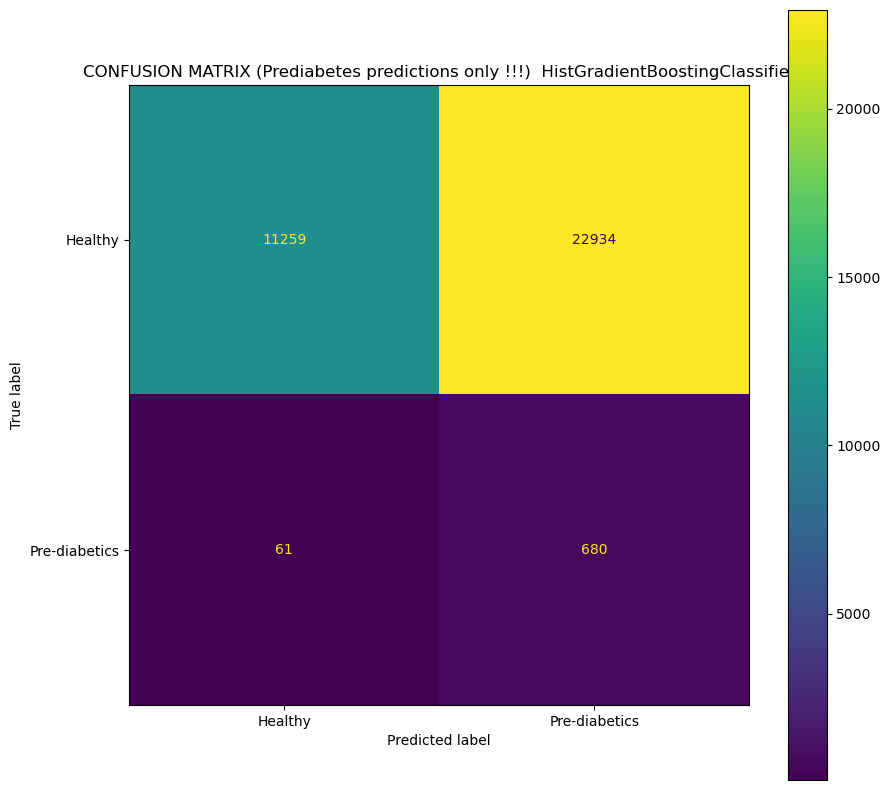

False alarms: 22934
Catches:  680
Ratio: 33.7
---------------------------------------------------------------------------------------------------------------------------


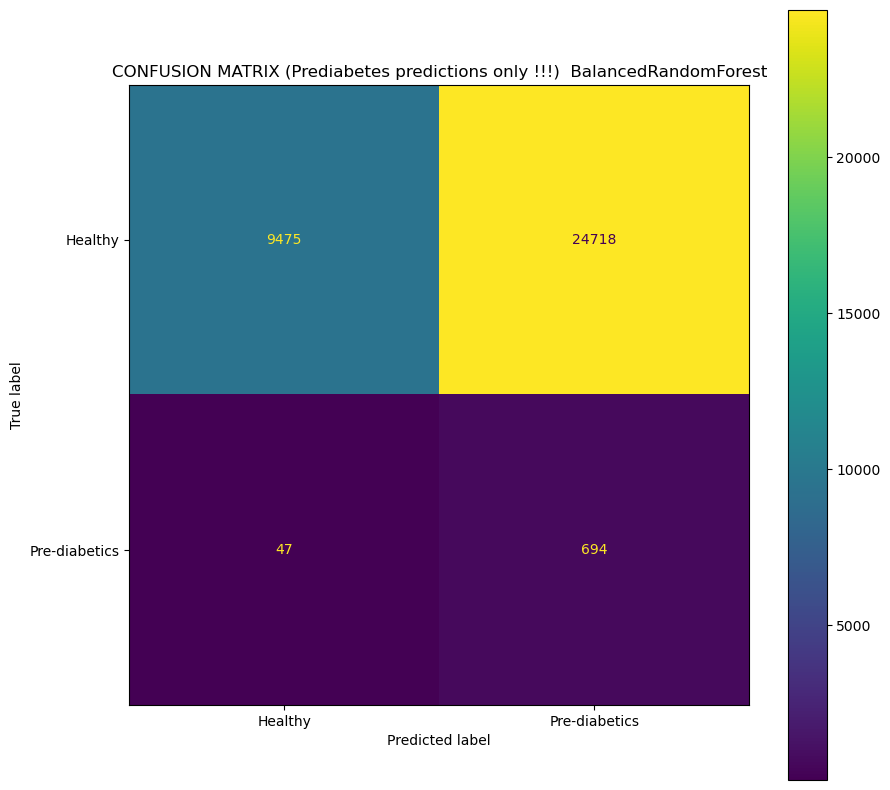

False alarms: 24718
Catches:  694
Ratio: 35.6
---------------------------------------------------------------------------------------------------------------------------


In [19]:
for name , model in models.items():

    # fit on train
    model.fit(x_train , y_train)
    # predict prediabetes (we have trained the model on y_train, that contains 3 classes)
    y_pred = predict_custom(model , x_test , 0.2)
    
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Pre-diabetics'])
    
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap='viridis', ax=ax, values_format='d') 
    plt.title(f"CONFUSION MATRIX (Prediabetes predictions only !!!)  {name}")
    plt.show()


    # Let's see how many healthy people misclassifications we have against correct disease classification
    print(f"False alarms: {cm[0,1]}\nCatches:  {cm[1,1]}\nRatio: {cm[0,1]/cm[1,1]:.1f}")
    print("---------------------------------------------------------------------------------------------------------------------------")

#### Confusion matrix at best threshold: disease vs healthy

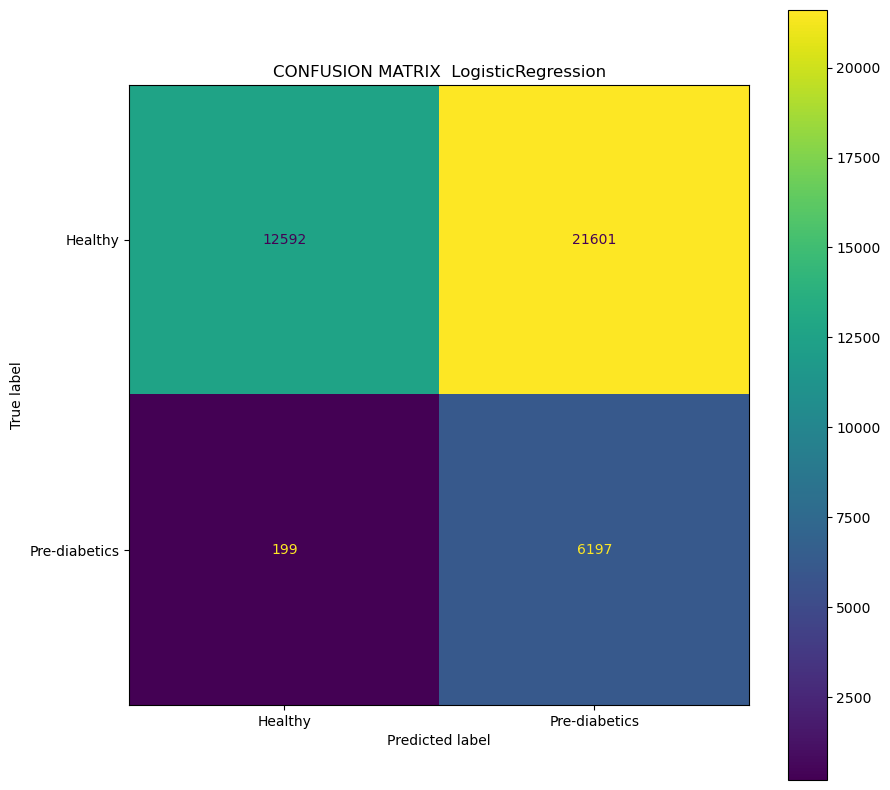

False alarms: 21601
Catches:  6197
Ratio: 3.5
---------------------------------------------------------------------------------------------------------------------------


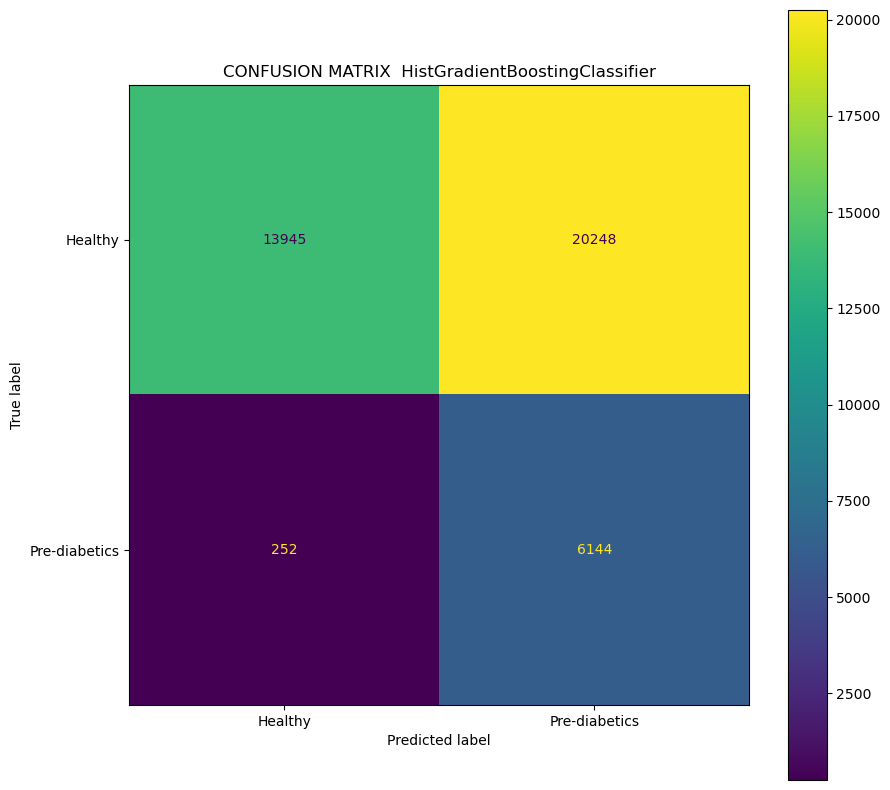

False alarms: 20248
Catches:  6144
Ratio: 3.3
---------------------------------------------------------------------------------------------------------------------------


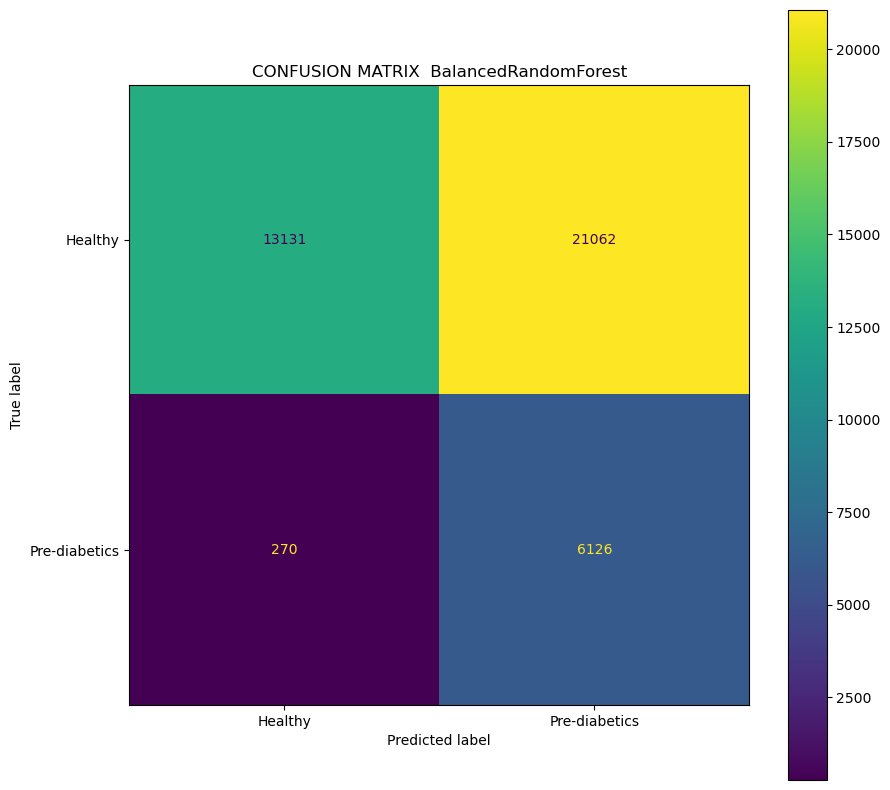

False alarms: 21062
Catches:  6126
Ratio: 3.4
---------------------------------------------------------------------------------------------------------------------------


In [21]:
# "binarize" the problem
y_train_first = np.where(y_train <= 1 , y_train , 1)
y_test_first = np.where(y_test <= 1 , y_test , 1)

# now same as before but we predict disease and healthy
for name , model in models.items():

    # fit on train
    model.fit(x_train , y_train_first)
    # predict disease
    y_pred = predict_custom(model , x_test , 0.2)
    
    cm = confusion_matrix(y_test_first, y_pred, labels=[0, 1])
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Pre-diabetics'])
    
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap='viridis', ax=ax, values_format='d') 
    plt.title(f"CONFUSION MATRIX  {name}")
    plt.show()


    # Let's see how many healthy people misclassifications we have against correct disease classification
    print(f"False alarms: {cm[0,1]}\nCatches:  {cm[1,1]}\nRatio: {cm[0,1]/cm[1,1]:.1f}")
    print("---------------------------------------------------------------------------------------------------------------------------")

#### 5. Results
Logistic regression, Balanced Random forest and HistGradientBoosting had similar performance. HistGradientBoosting showed the highest specificity while the other models exibhit worse specificty at similar thresholds, with a recall close to 92% (BalancedRandom forest) or 93% (Logistic regression) against a 91% recall of the HistgradientBoosting.
The truth is that these models are all very similar.
With HistGradientBoosting at threshold 0.2 we spot 91% of prediabetics and we correctly classify almost 41% of healthy people, and considering a screening use case for the model, it is very important to also keep the number of misclassifications of healthy people as low as possible.
A 2% of healthy people are lot more people than a 2% of disease. 
On the other hand, LogistiRegression has the highest recall for diesease, and also the highest ratio (false alarms against correct disease classifications), which is inconvenient. However, it could be the best model if the absolute priority to take as much diabetics and prediabetics as possible.  

I will continue only with LogisticRegression and HistGradientBoosting.  
In the next script I will focus on the second-tier classifier.